In [29]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import time
import pickle
from bagpy import bagreader
import open3d as o3d
import sensor_msgs.point_cloud2 as pc2
from rosbags.image import message_to_cvimage
import pyrealsense2 as rs2
if (not hasattr(rs2, 'intrinsics')):
    import pyrealsense2.pyrealsense2 as rs2

In [40]:
# load test images from crowdbot dataset
path = os.path.join("/home/pbr-student/personal/thesis/crowdbot/rosbags/zips/rosbags_25_03_shared_control-rgbd_defaced", "defaced_2021-03-25-14-54-51.bag")
bag = bagreader(path).reader

def msgs(bag, topic1, topic2):
    topic_list = [
        topic1,
        topic2
    ]
    msgs = []
    msgs2 = []
    for topic, msg, t in bag.read_messages(topics=topic_list):
        if topic == topic1:
            msgs.append(msg)
        if topic == topic2:
            msgs2.append(msg)
    bag.close()
    return msgs, msgs2

def create_detection_data(msgs):
    timestamps = []
    detections = []
    for i in msgs:
        timestamps.append(i.header.stamp.to_time())
        detection = []
        # reduce information about each detection to the necessary things
        for j in i.detections:
            # save from detections: confidence score, positionx, positiony, positionz, bboxx, bboxy, bboxw, bboxh
            conf_score = j.confidence
            pos = [j.pose.pose.position.x, j.pose.pose.position.y, j.pose.pose.position.z]
            bbox = [j.bbox_x, j.bbox_y, j.bbox_w, j.bbox_h]
            detection.append([conf_score, pos, bbox])
        detections.append(detection)
    data = {"timestamps": np.array(timestamps), "detections": detections}
    return data

def create_img_data(msgs):
    timestamps = []
    img_msgs = []
    for i in msgs:
        timestamps.append(i.header.stamp.to_time())
        img = message_to_cvimage(i)
        img_msgs.append(img)
    data = {"timestamps": np.array(timestamps), "img_msgs": img_msgs}
    return data

det_msgs, img_msgs = msgs(bag, "/detected_persons/yolo", "/camera_left/color/image_raw")

d1 = create_detection_data(det_msgs)
d2 = create_img_data(img_msgs)

pd.set_option('display.float_format', '{:.2f}'.format)
df_pers = pd.DataFrame.from_dict(data=d1)
df_img = pd.DataFrame.from_dict(data=d2)

df_pers.sort_values(by="timestamps",inplace=True)
df_img.sort_values(by="timestamps",inplace=True)

merged_df = pd.merge_asof(df_pers, df_img, on="timestamps", direction="nearest")

# get imgs and bboxes
imgs = merged_df.iloc[:500]["img_msgs"]

bboxes = []
scores = []
for d in merged_df.iloc[:500]["detections"]:
    bbox_d = []
    scores_d = []
    for i in d:
        x_min, y_min, w, h = i[2]
        bbox_d.append([int(x_min), int(y_min), int(x_min+w), int(y_min+h)])
        scores_d.append([i[0]])
    bboxes.append(bbox_d)
    scores.append(scores_d)

[INFO]  Data folder /home/pbr-student/personal/thesis/crowdbot/rosbags/zips/rosbags_25_03_shared_control-rgbd_defaced/defaced_2021-03-25-14-54-51 already exists. Not creating.


# MoveNet

In [104]:
# Load movenet
pose_sample_rpi_path = os.path.join(os.path.dirname(os.getcwd()), 'examples/lite/examples/pose_estimation/raspberry_pi')

sys.path.append(pose_sample_rpi_path)
import utils
from ml import Movenet
movenet = Movenet('../pretrained/movenet_thunder')

def detect(input_tensor, inference_count=3):
  image_height, image_width, channel = input_tensor.shape
 
  # Detect pose using the full input image
  movenet.detect(input_tensor, reset_crop_region=True)
 
  # Repeatedly using previous detection result to identify the region of
  # interest and only croping that region to improve detection accuracy
  for _ in range(inference_count - 1):
    person = movenet.detect(input_tensor, 
                            reset_crop_region=False)

  return person

def draw_prediction_on_image(
    image, person, crop_region=None, close_figure=True,
    keep_input_size=False):
  # Draw the detection result on top of the image.
  image_np = utils.visualize(image, [person])
  
  # Plot the image with detection results.
  height, width, channel = image.shape
  aspect_ratio = float(width) / height
  fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
  im = ax.imshow(image_np)
 
  if close_figure:
    plt.close(fig)
 
  if not keep_input_size:
    image_np = utils.keep_aspect_ratio_resizer(image_np, (512, 512))

  return image_np

def get_pose2(frame, bbox):
    #offset = 0
    #cropped_img = frame.copy()[bbox[1]-offset:bbox[3]+offset, bbox[0]-offset:bbox[2]+offset]
    cropped_img = frame.copy()[bbox[1]:bbox[3], bbox[0]:bbox[2]]
    cropped_img = np.asarray(cropped_img.copy(),dtype=np.uint8)
    #cropped_img = frame.copy()
    person = detect(cropped_img)

    #print(person)
    detections = []
    if len(person.keypoints) > 0:
        output_overlay = draw_prediction_on_image(
              cropped_img.astype(np.uint8), person, 
              close_figure=True, keep_input_size=True)
        output_frame = cv.cvtColor(output_overlay, cv.COLOR_RGB2BGR)
        for keypoint in person.keypoints:
            detections.append(keypoint.score)
    return output_frame, np.asarray(detections)

In [84]:
def vis_movenet(fig, columns, rows, idx):
    frames = []
    coord_scores = []
    for bbox in bboxes[idx]:
        img, det = get_pose2(imgs[idx], bbox)
        frames.append(img)
        coord_scores.append(det)

    for f in range(len(frames)):
        fig.add_subplot(rows, columns, f+1) 
        plt.imshow(frames[f])
        plt.axis('off') 
        plt.title(str(f)) 

    return coord_scores

# BlazePose

In [101]:
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import numpy as np

# set base options for blazepose
base_options = python.BaseOptions(model_asset_path='../pretrained/pose_landmarker.task')
options = vision.PoseLandmarkerOptions(
    base_options=base_options,
    output_segmentation_masks=True)
detector = vision.PoseLandmarker.create_from_options(options)

def draw_landmarks_on_image(rgb_image, detection_result):
  pose_landmarks_list = detection_result.pose_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected poses to visualize.
  for idx in range(len(pose_landmarks_list)):
    pose_landmarks = pose_landmarks_list[idx]

    # Draw the pose landmarks.
    pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    pose_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      pose_landmarks_proto,
      solutions.pose.POSE_CONNECTIONS,
      solutions.drawing_styles.get_default_pose_landmarks_style())
  return annotated_image

def get_pose(frame, bbox):
    offset = 0
    cropped_img = frame.copy()[bbox[1]:bbox[3], bbox[0]:bbox[2]]
    cropped_img = np.asarray(cropped_img.copy(),dtype=np.uint8)
    #cropped_img = frame.copy()
    mp_im = mp.Image(image_format=mp.ImageFormat.SRGB, data=cropped_img)
    detection_result = detector.detect(mp_im)
    #print(detection_result)
    annotated_image = draw_landmarks_on_image(cropped_img, detection_result)
    #if len(detection_result.pose_landmarks) > 0:
      #annotated_image
    return annotated_image, detection_result
        

I0000 00:00:1716460692.708678    8046 task_runner.cc:85] GPU suport is not available: INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:77) display != EGL_NO_DISPLAYeglGetDisplay() returned error 0x300c


In [66]:
def vis_blazepose(fig, columns, rows, idx):
    frames = []
    coord_scores = []
    for bbox in bboxes[idx]:
        img, det = get_pose(imgs[idx], bbox)
        frames.append(img)
        coord_scores.append(det)
    
    for f in range(len(frames)):
        fig.add_subplot(rows, columns, f+1+len(frames)) 
        plt.imshow(frames[f])
        plt.axis('off') 
        plt.title(str(f)) 

# Comparison between MoveNet and BlazePose

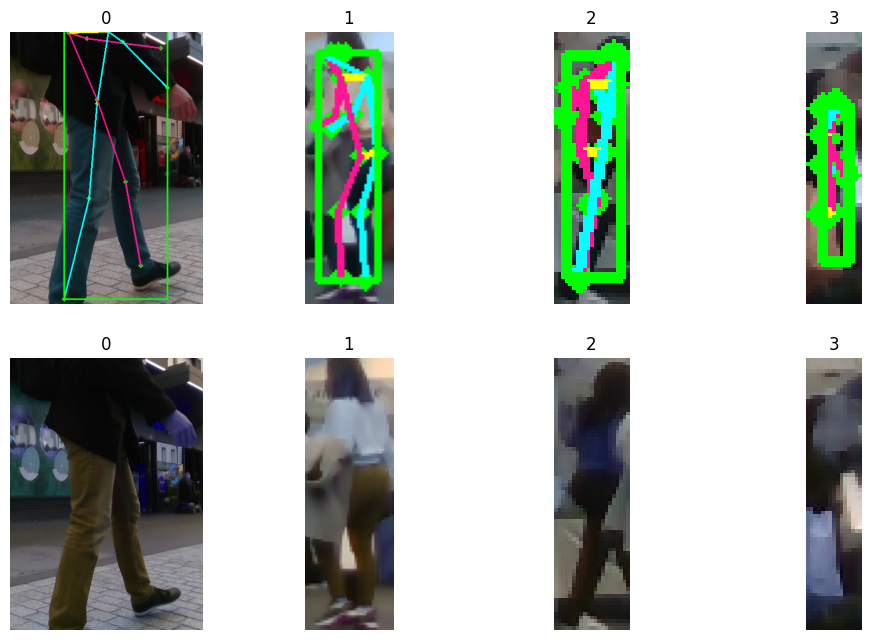

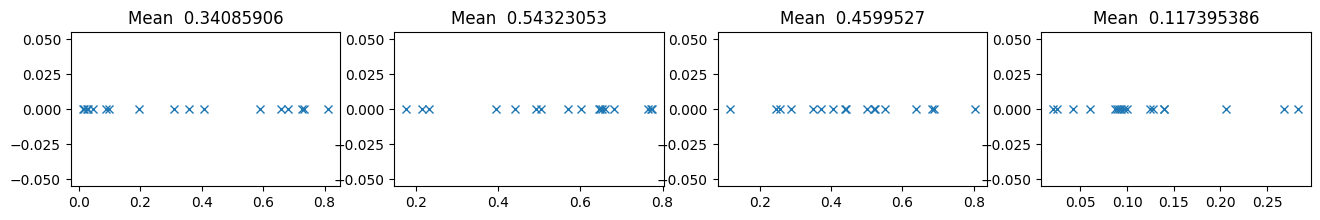

In [106]:
idx = 78
rows = 3
columns = len(bboxes[idx])

fig = plt.figure(figsize=(columns*3,4*rows))

coord_scores = vis_movenet(fig, columns, rows, idx)
vis_blazepose(fig, columns, rows, idx)

fig2, axs= plt.subplots(1, columns, figsize=((columns*4,2)))

for i in range(len(coord_scores)):
    axs[i].plot(coord_scores[i], np.zeros_like(coord_scores[i]), 'x')
    title = "Mean  " + str(np.mean(coord_scores[i]))
    axs[i].title.set_text(title)